In [22]:
"""
# LeBron James Shot Prediction (2024–25)
This notebook analyzes LeBron James's shot data from the 2024–25 NBA season.

Goals:
- Explore shot distributions and accuracy by location
- Visualize shot frequency and field goal %
- Build a machine learning model to predict shot success
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning later
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Load cleaned data
df = pd.read_csv("C:/Users/BC-Tech/Documents/Chibueze's Personal Coding Projects/Personal-Projects-1/basketball-shot-predictor/data/processed/lebron_shots_cleaned_2024_25.csv")


In [23]:
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1270 entries, 0 to 1269
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   GAME_ID              1270 non-null   int64 
 1   GAME_DATE            1270 non-null   object
 2   PERIOD               1270 non-null   int64 
 3   MINUTES_REMAINING    1270 non-null   int64 
 4   SECONDS_REMAINING    1270 non-null   int64 
 5   SHOT_DISTANCE        1270 non-null   int64 
 6   LOC_X                1270 non-null   int64 
 7   LOC_Y                1270 non-null   int64 
 8   SHOT_ZONE_BASIC      1270 non-null   object
 9   ACTION_TYPE          1270 non-null   object
 10  SHOT_TYPE            1270 non-null   object
 11  SHOT_ZONE_AREA       1270 non-null   object
 12  SHOT_ATTEMPTED_FLAG  1270 non-null   int64 
 13  SHOT_MADE_FLAG       1270 non-null   int64 
 14  LATE_GAME            1270 non-null   int64 
 15  THREE_POINT_SHOT     1270 non-null   int64 
dtypes: int

,GAME_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,LATE_GAME,THREE_POINT_SHOT
count,1.270000e+03,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.0,1270.000000,1270.000000,1270.000000
mean,2.240058e+07,2.599213,6.100000,29.011024,12.949606,-16.214961,102.385827,1.0,0.512598,0.062205,0.311811
std,3.424174e+02,1.125323,3.671746,16.962292,10.562090,92.255753,99.835006,0.0,0.500038,0.241622,0.463416
min,2.240002e+07,1.000000,0.000000,0.000000,0.000000,-244.000000,-32.000000,1.0,0.000000,0.000000,0.000000
25%,2.240030e+07,2.000000,2.000000,15.000000,3.000000,-64.750000,17.000000,1.0,0.000000,0.000000,0.000000
50%,2.240058e+07,3.000000,7.000000,29.000000,11.000000,-7.000000,54.000000,1.0,1.000000,0.000000,0.000000
75%,2.240085e+07,4.000000,9.000000,44.000000,25.000000,19.000000,196.750000,1.0,1.000000,0.000000,1.000000
max,2.240122e+07,5.000000,11.000000,59.000000,67.000000,250.000000,667.000000,1.0,1.000000,1.000000,1.000000


In [24]:
print("Total shot attempts:", len(df))

Total shot attempts: 1270


In [25]:
# Draw the basketball court
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2):
    if ax is None:
        ax = plt.gca()

    # Court Outline
    outer = Rectangle((-250, -47.5), 500, 470, linewidth=lw, color=color, fill=False)

    # Hoop
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # Paint
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color, fill=False)
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color, fill=False)

    # Free throw arc
    free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180, linewidth=lw, color=color)

    # Three-point arc
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw, color=color)

    # Side 3pt lines
    side1 = Rectangle((-220, -47.5), 0, 140, linewidth=lw, color=color)
    side2 = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)

    # Add to axes
    elements = [outer, hoop, backboard, outer_box, inner_box,
                free_throw, three_arc, side1, side2]
    for e in elements:
        ax.add_patch(e)

    return ax


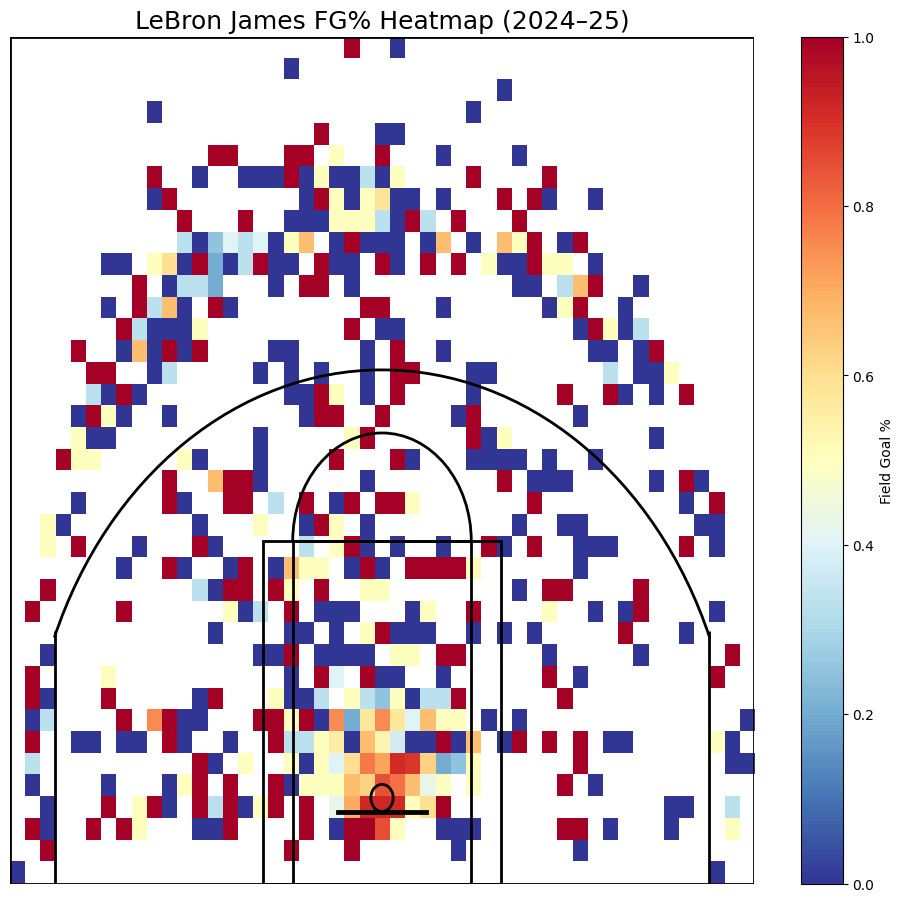

In [26]:
# Create bins (e.g., 20x20 pixel grid)
x_bins = np.linspace(-250, 250, 50)
y_bins = np.linspace(-47.5, 422.5, 50) 

## Bin shot locations
df["X_BIN"] = pd.cut(df["LOC_X"], bins=x_bins, labels=False)
df["Y_BIN"] = pd.cut(df["LOC_Y"], bins=y_bins, labels=False)

# Group by bins and calculate FG%
binned_fg = df.groupby(["X_BIN", "Y_BIN"])["SHOT_MADE_FLAG"].mean().unstack()

# Plot FG% by location
plt.figure(figsize=(12, 11))
ax = plt.gca()
draw_court(ax)

# Plot the binned FG% heatmap
plt.imshow(
    binned_fg.T,
    extent=[-250, 250, -47.5, 422.5],
    origin='lower',
    cmap='RdYlBu_r',
    aspect='auto',
    interpolation='nearest'
)

plt.colorbar(label="Field Goal %")
plt.title("LeBron James FG% Heatmap (2024–25)", fontsize=18)
plt.axis('off')
plt.show()

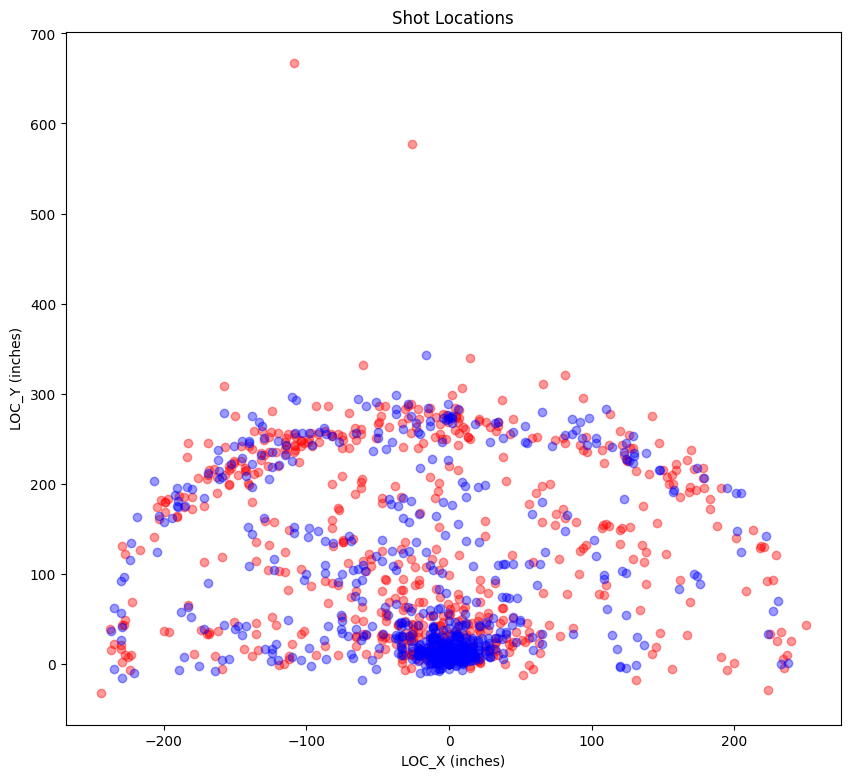

In [27]:
#To visualize the shot locations, we will plot the x and y coordinates of each shot.
# The x and y coordinates represent the location of the shot on the court.
# Separate made and missed shots
draw_court(ax)  # Draw the court first
made_shots = df[df['SHOT_MADE_FLAG'] == 1]
missed_shots = df[df['SHOT_MADE_FLAG'] == 0]

plt.figure(figsize=(10, 9))

# Plot missed shots in red
plt.scatter(missed_shots['LOC_X'], missed_shots['LOC_Y'], color='red', alpha=0.4, label='Missed Shot')

# Plot made shots in blue
plt.scatter(made_shots['LOC_X'], made_shots['LOC_Y'], color='blue', alpha=0.4, label='Made Shot')

plt.title('Shot Locations')
plt.xlabel('LOC_X (inches)')
plt.ylabel('LOC_Y (inches)')
plt.show()

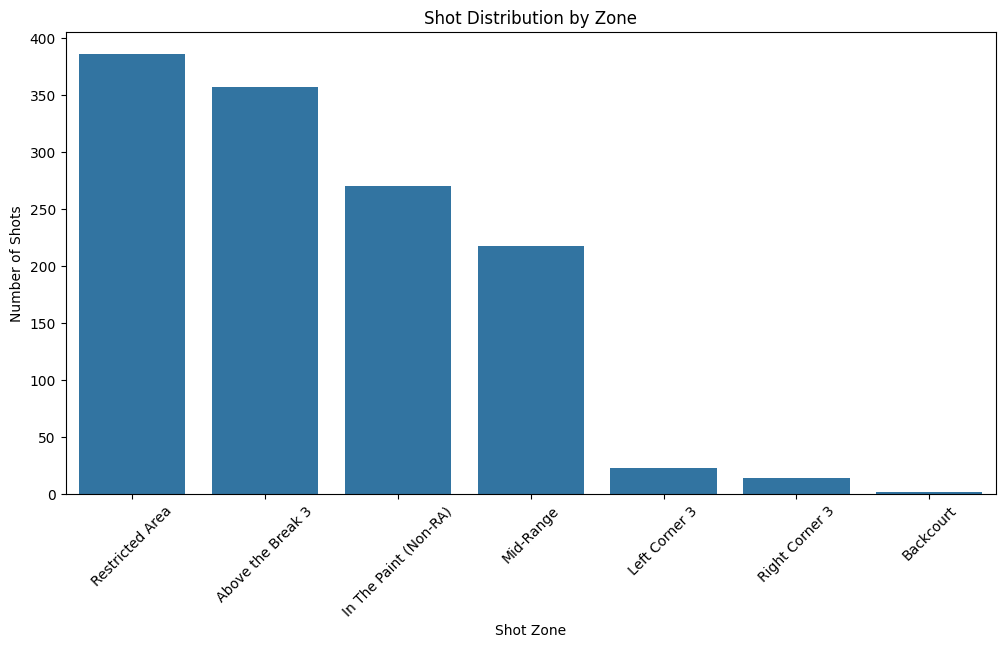

In [28]:
# Shot Distribution and Selection
df['SHOT_ZONE_BASIC'].value_counts()
# Visualize shot distribution by zone
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='SHOT_ZONE_BASIC', order=df['SHOT_ZONE_BASIC'].value_counts().index)
plt.title('Shot Distribution by Zone')
plt.xticks(rotation=45)
plt.xlabel('Shot Zone')
plt.ylabel('Number of Shots')
plt.show()


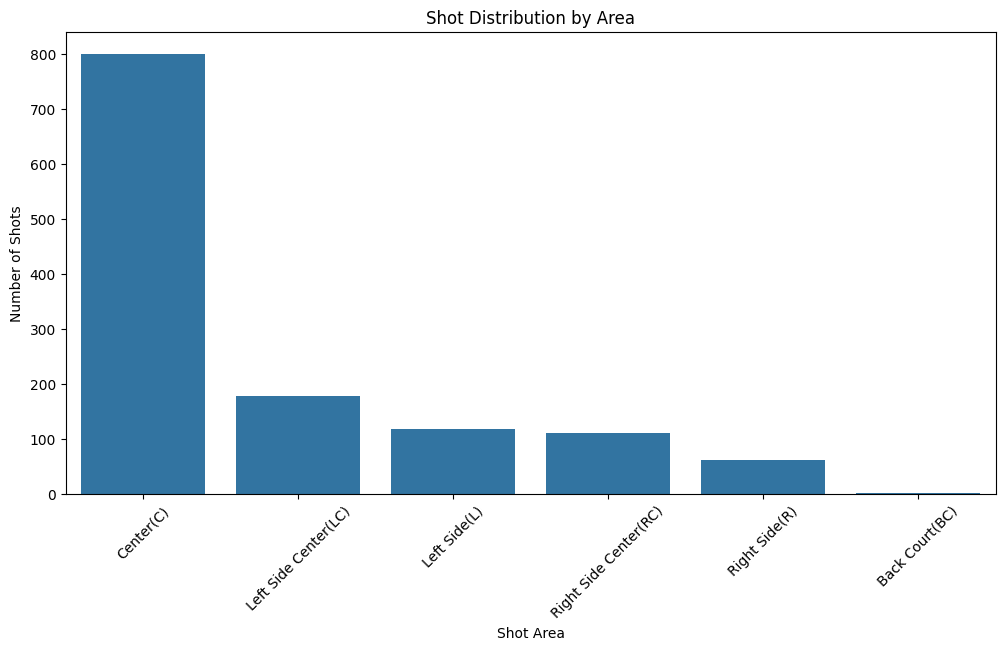

In [29]:
# Favourite Shot Zones
df['SHOT_ZONE_AREA'].value_counts()
# Visualize shot distribution by area
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='SHOT_ZONE_AREA', order=df['SHOT_ZONE_AREA'].value_counts().index)
plt.title('Shot Distribution by Area')
plt.xticks(rotation=45)
plt.xlabel('Shot Area')
plt.ylabel('Number of Shots')
plt.show()
# Visualize shot accuracy by area

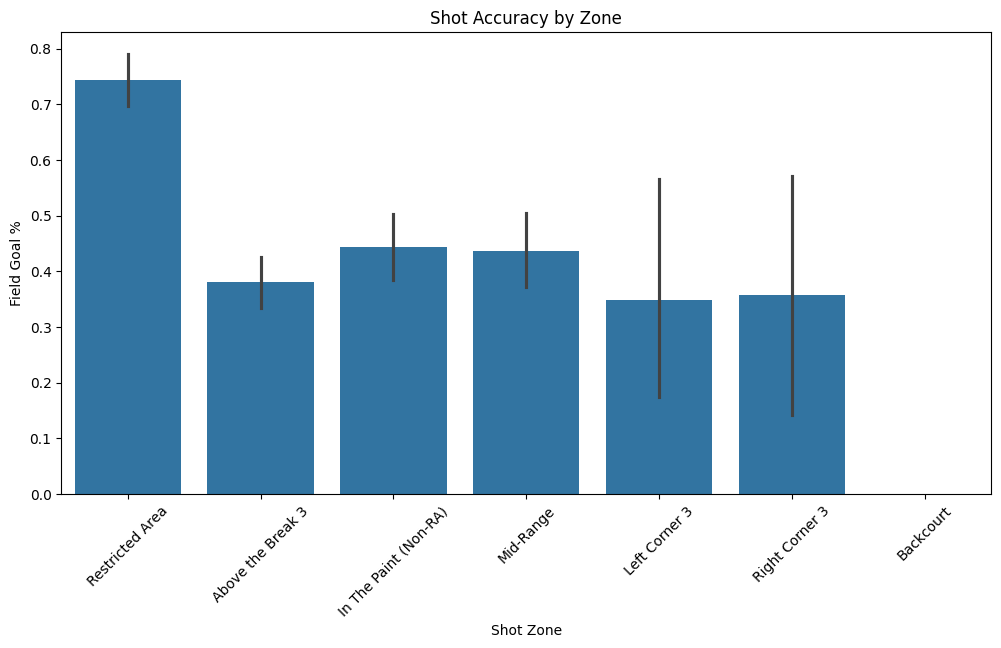

In [30]:
# Shot Success Distribution
df['SHOT_MADE_FLAG'].value_counts()
# Visualize shot accuracy by zone
plt.figure(figsize=(12, 6))
# the average field goal percentage by shot zone is calculated by grouping the data by 'SHOT_ZONE_BASIC' and taking the mean of 'SHOT_MADE_FLAG'
sns.barplot(data=df, x='SHOT_ZONE_BASIC', y='SHOT_MADE_FLAG', order=df['SHOT_ZONE_BASIC'].value_counts().index)
plt.title('Shot Accuracy by Zone')  
plt.xticks(rotation=45)
plt.xlabel('Shot Zone')
plt.ylabel('Field Goal %')
plt.show()


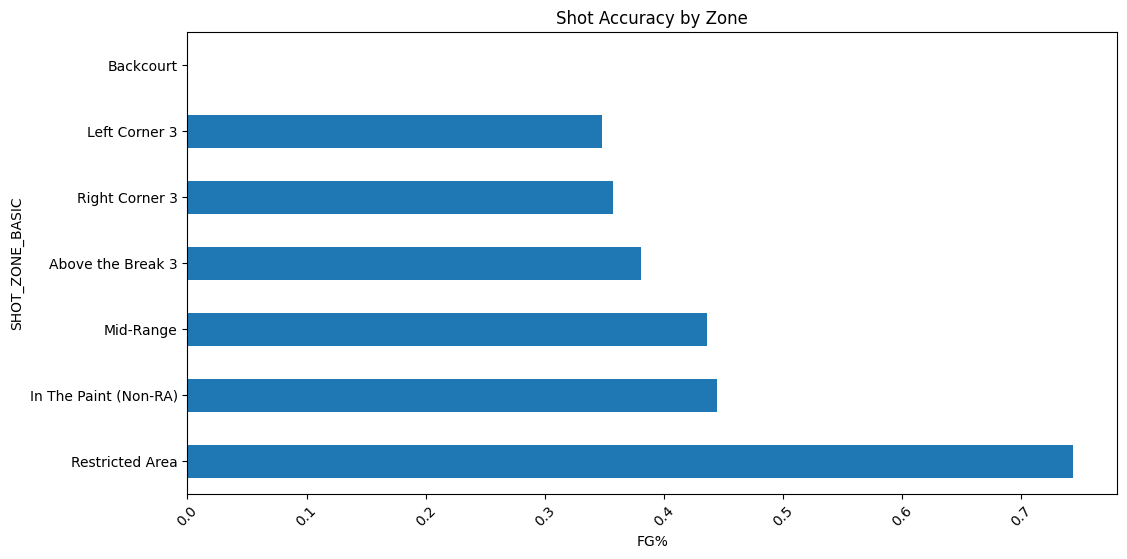

In [31]:
# Visualize shot accuracy by area
plt.figure(figsize=(12, 6))
zone_success = df.groupby("SHOT_ZONE_BASIC")["SHOT_MADE_FLAG"].mean().sort_values(ascending=False)
zone_success.plot(kind='barh', title='FG% by Shot Zone')
plt.title('Shot Accuracy by Zone')  
plt.xticks(rotation=45)
plt.xlabel("FG%")
plt.show()


In [66]:
categorical_cols = ["SHOT_TYPE"]

# One-hot encode and join with your main DataFrame
df_encoded = pd.get_dummies(df, columns=categorical_cols)
print (df_encoded)

features = ["SHOT_DISTANCE", "PERIOD", "MINUTES_REMAINING", "SECONDS_REMAINING","LOC_X", "LOC_Y", "LATE_GAME"] + [col for col in df_encoded.columns if any(cat in col for cat in categorical_cols)]
X = df_encoded[features]
y = df_encoded["SHOT_MADE_FLAG"]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



df.head(25)

       GAME_ID                      GAME_DATE  PERIOD  MINUTES_REMAINING  \
0     22400015  1970-01-01 00:00:00.020241115       1                 10   
1     22400015  1970-01-01 00:00:00.020241115       1                  8   
2     22400015  1970-01-01 00:00:00.020241115       1                  1   
3     22400015  1970-01-01 00:00:00.020241115       2                 10   
4     22400015  1970-01-01 00:00:00.020241115       2                  8   
...        ...                            ...     ...                ...   
1265  22401220  1970-01-01 00:00:00.020241215       4                 11   
1266  22401220  1970-01-01 00:00:00.020241215       4                  8   
1267  22401220  1970-01-01 00:00:00.020241215       4                  4   
1268  22401220  1970-01-01 00:00:00.020241215       4                  2   
1269  22401220  1970-01-01 00:00:00.020241215       4                  1   

      SECONDS_REMAINING  SHOT_DISTANCE  LOC_X  LOC_Y        SHOT_ZONE_BASIC  \
0       

,GAME_ID,GAME_DATE,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ZONE_BASIC,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_AREA,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,LATE_GAME,THREE_POINT_SHOT,X_BIN,Y_BIN
0,22400015,1970-01-01 00:00:00.020241115,1,10,44,5,56,-1,In The Paint (Non-RA),Turnaround Jump Shot,2PT Field Goal,Center(C),1,0,0,0,29,4.0
1,22400015,1970-01-01 00:00:00.020241115,1,8,43,1,-10,4,Restricted Area,Running Finger Roll Layup Shot,2PT Field Goal,Center(C),1,1,0,0,23,5.0
2,22400015,1970-01-01 00:00:00.020241115,1,1,18,0,0,0,Restricted Area,Tip Layup Shot,2PT Field Goal,Center(C),1,1,0,0,24,4.0
3,22400015,1970-01-01 00:00:00.020241115,2,10,53,3,-12,29,Restricted Area,Running Layup Shot,2PT Field Goal,Center(C),1,1,0,0,23,7.0
4,22400015,1970-01-01 00:00:00.020241115,2,8,9,1,11,14,Restricted Area,Running Finger Roll Layup Shot,2PT Field Goal,Center(C),1,0,0,0,25,6.0
5,22400015,1970-01-01 00:00:00.020241115,2,7,3,25,-185,176,Above the Break 3,Jump Shot,3PT Field Goal,Left Side Center(LC),1,1,0,1,6,23.0
6,22400015,1970-01-01 00:00:00.020241115,3,9,31,2,-11,21,Restricted Area,Running Layup Shot,2PT Field Goal,Center(C),1,1,0,0,23,7.0
7,22400015,1970-01-01 00:00:00.020241115,3,5,17,27,-138,239,Above the Break 3,Step Back Jump shot,3PT Field Goal,Left Side Center(LC),1,0,0,1,10,29.0
8,22400015,1970-01-01 00:00:00.020241115,3,4,22,27,5,274,Above the Break 3,Running Pull-Up Jump Shot,3PT Field Goal,Center(C),1,0,0,1,24,33.0
9,22400015,1970-01-01 00:00:00.020241115,3,0,46,28,-130,249,Above the Break 3,Jump Shot,3PT Field Goal,Left Side Center(LC),1,0,0,1,11,30.0


In [67]:
# Train a Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

#Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

C:\Users\BC-Tech\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [68]:
y_pred = lr_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))

y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))


Accuracy: 0.6220472440944882
Random Forest Accuracy: 0.5905511811023622


In [73]:
importances = rf_model.feature_importances_
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)
print(feature_importance)

LOC_X                       0.211810
LOC_Y                       0.209838
SECONDS_REMAINING           0.197671
SHOT_DISTANCE               0.158850
MINUTES_REMAINING           0.118706
PERIOD                      0.070386
SHOT_TYPE_3PT Field Goal    0.011967
SHOT_TYPE_2PT Field Goal    0.011847
LATE_GAME                   0.008927
dtype: float64
